# Imports and setup

In [1]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [2]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [8]:
# Setup the environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [11]:
env.action_space

Discrete(7)

In [ ]:
done = True
for step in range(100000):
  if done:
    # Start a fresh game
    env.reset()
  
  # Do random actions
  state, reward, done, info = env.step(env.action_space.sample())

  # Show the game on screen
  env.render()

# Close the game
env.close()

# Preprocess Environment

In [3]:
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

/opt/homebrew/anaconda3/envs/rlsb3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# Wrap in the dummy environment
env = DummyVecEnv([lambda: env])
# Stack the frames
env = VecFrameStack(env, n_stack=4, channels_order='last')

In [5]:
state = env.reset()
state.shape

(1, 240, 256, 4)

In [6]:
state, reward, done, info = env.step([env.action_space.sample()])

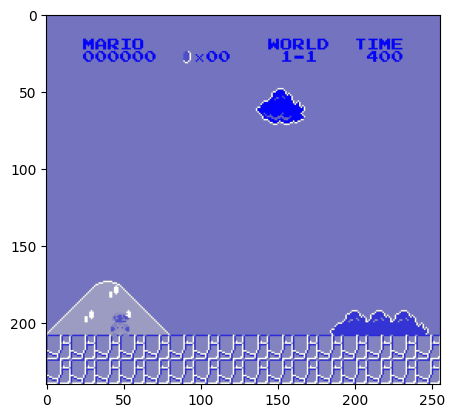

In [7]:
# Use matplotlib to show the game frame
plt.imshow(state[0])

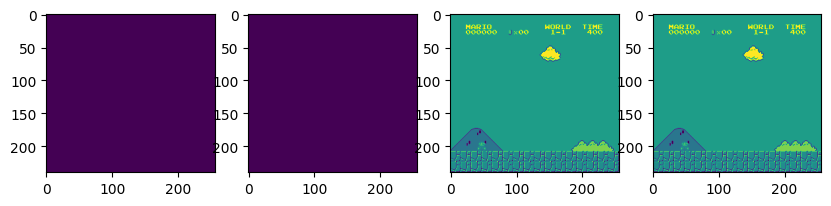

In [8]:
plt.figure(figsize=(10, 8))
for i in range(state.shape[3]):
  plt.subplot(1, 4, i+1)
  plt.imshow(state[0][:, :, i])

plt.show()

# Train the RL Model

In [9]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [10]:
class TrainAndLoggingCallback(BaseCallback):
  def __init__(self, check_freq, save_path, verbose: int = 1):
    super(TrainAndLoggingCallback, self).__init__(verbose)
    self.check_freq = check_freq
    self.save_path = save_path

  def _init_callback(self):
    if self.save_path is not None:
      os.makedirs(self.save_path, exist_ok=True)

  def _on_step(self):
    if self.n_calls % self.check_freq == 0:
      model_path = os.path.join(self.save_path, f'best_model_{self.n_calls}')
      self.model.save(model_path)
      
    return True


In [11]:
CHECKPOINT_DIR = './mario/train/'
LOG_DIR = './mario/logs/'

In [12]:
# Setup periodic model saving
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [13]:
# This is the ai model
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=1e-5, n_steps=512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [14]:
! pip install tensorboard

In [15]:
# train the ai model
model.learn(total_timesteps=1000000, callback=callback)

Logging to ./mario/logs/PPO_1
----------------------------
| time/              |     |
|    fps             | 126 |
|    iterations      | 1   |
|    time_elapsed    | 4   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 2            |
|    time_elapsed         | 62           |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0044552186 |
|    clip_fraction        | 0.00762      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.94        |
|    explained_variance   | 0.00349      |
|    learning_rate        | 1e-05        |
|    loss                 | 123          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00581     |
|    value_loss           | 291          |
------------------------------------

# Test it out